# Diplomado ML & DS 
# Sesión 4: Máquinas de vectores de soporte y selección de modelos

Definimos primero unas librerías y funciones que vamos a usar a durante la sesión:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize


# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def plot_labels(n_folds, n_classes, list_labels):
    ind = np.arange(n_folds)
    width = 0.15
    
    countings = []
    for labels in list_labels:
        labels = np.array(labels)
        countings.append([np.count_nonzero(labels == x) for x in range(n_classes)])
    
    class_bars = []
    for cls in range(n_classes):
        class_bars.append([l[cls] for l in countings])
    
    fig, ax = pl.subplots()
    i = 0
    for class_bar in class_bars:
        ax.bar(ind + width*i, class_bar, width, label='Clase '+str(i))
        i += 1
        
    ax.set_xticks(ind + 2*width / 3)
    ax.set_xticklabels(['Pliegue {}'.format(k) for k in range(n_folds)])
    pl.legend(loc="best")
    pl.title("Etiquetas")

# Máquinas de vectores de soporte

Las máquinas de vectores de soporte son un modelo de aprendizaje supervisado en el cual los ejemplos son representados en un nuevo espacio, de tal forma que aquellos ejemplos de diferentes categorías sea posible, en principio, separarlos linealmente. Considere el siguiente ejemplo de un conjunto de datos.

In [2]:
from sklearn.datasets import make_circles, make_moons

np.random.seed(0)

X, y = make_circles(n_samples=1000, factor=.3, noise=.05)

Se trata de un conjunto de datos que no es linealmente separable

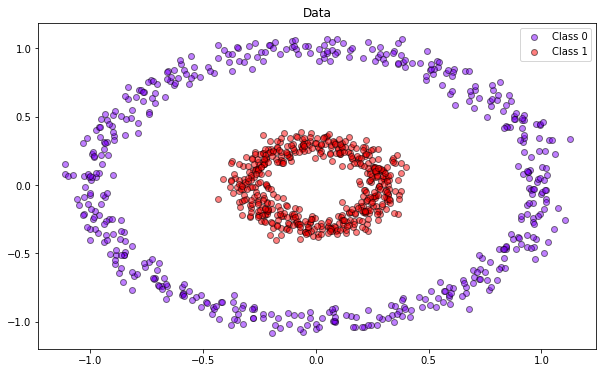

In [3]:
pl.figure(figsize = (10, 6))
plot_data(X, y)

**¿Cómo separar los datos?**

SVM  crea, implícitamente, un espacio de representación de mayor dimensionalidad en el cual podemos separar de forma clara nuestros datos. Por ejemplo:

<img src="figures/kernel_trick.png" width="100%">

## Kernel trick

SVM usa una función conocida como kernel. Intuitivamente, esta función $k$ define qué tan parecidas son dos instancias del conjunto de datos. Formalmente, la función $k$ calcula el producto punto en el espacio de caracterísiticas donde se representarán los datos. Dependiendo del kernel, este espacio de característica es de mayor dimensionalidad, y facilita la  definición de un "*hiperplano*" que separe los ejemplos de ambas características. 

Existen varias opciones para las funciones de kernel. Primero vamos a cargar dos conjuntos de datos sobre los cuales vamos a comparar la superficie de decisión generada por cada tipo de kernel. 

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X_iris = iris.data[:,[0, 2]] 
y_iris = iris.target
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, 
                                                                        y_iris, 
                                                                        test_size=0.3, 
                                                                        random_state=1)

X_moons, y_moons = make_moons(n_samples=600, noise=0.3, random_state=0)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons, 
                                                                            y_moons, 
                                                                            test_size=0.3, 
                                                                            random_state=1)

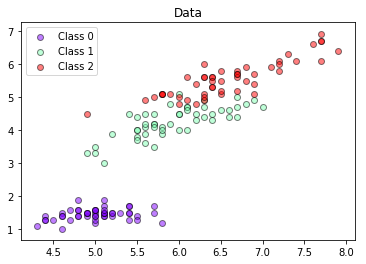

In [5]:
plot_data(X_iris, y_iris)

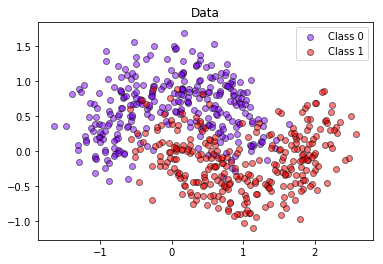

In [6]:
plot_data(X_moons, y_moons)

## Kernel Lineal

La función $k$ está definida como:
$$
k(x,y) = \langle x, x\rangle = xx'
$$

Esta implementación puede ser consultada a través de `sklearn.svm.LinearSVC`.

In [7]:
from sklearn.svm import LinearSVC

linear_iris = LinearSVC()
linear_moons = LinearSVC()

linear_iris.fit(X_train_iris, y_train_iris)
linear_moons.fit(X_train_moons, y_train_moons);

Ahora visualizamos los datos de ambos:

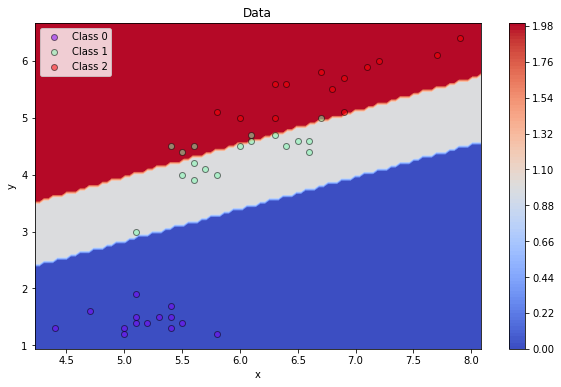

In [8]:
pl.figure(figsize = (10, 6))    
plot_decision_region(X_test_iris, gen_pred_fun(linear_iris))
plot_data(X_test_iris, y_test_iris)

El error en el conjunto de entrenamiento y prueba es el siguiente:

In [9]:
print("Error en entrenamiento: {}".format(1-linear_iris.score(X_train_iris, y_train_iris)))
print("Error en prueba: {}".format(1-linear_iris.score(X_test_iris, y_test_iris)))

Error en entrenamiento: 0.04761904761904767
Error en prueba: 0.11111111111111116


Ahora hacemos los mismo para el conjunto de datos generado artificialmente:

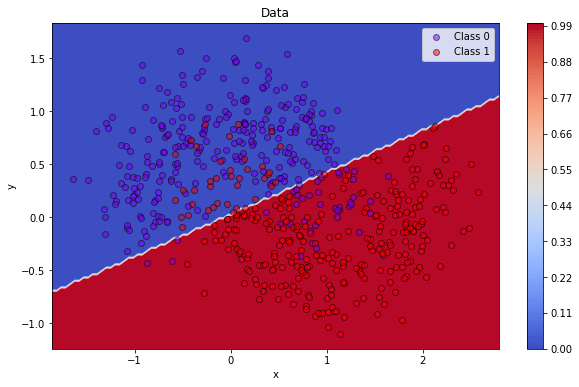

In [10]:
pl.figure(figsize = (10, 6))    
plot_decision_region(X_moons, gen_pred_fun(linear_moons))
plot_data(X_moons, y_moons)

In [11]:
print("Error en entrenamiento: {}".format(1-linear_moons.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-linear_moons.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.12380952380952381
Error en prueba: 0.15000000000000002


## Kernel polinomial

La función $k$ está definida como:
$$
k(x,y) = (\gamma \langle x, x'\rangle + r)^d
$$
dónde $d$ corresponde al grado del polinomio. De manera similar podemos acceder a la implementación de este kernel a través de `sklearn.svm.SVC`. Definimos primero un kernel polinomial de grado 2.

In [12]:
from sklearn.svm import SVC

poly_svm = SVC(kernel='poly', degree=2)
poly_svm.fit(X_train_moons, y_train_moons);

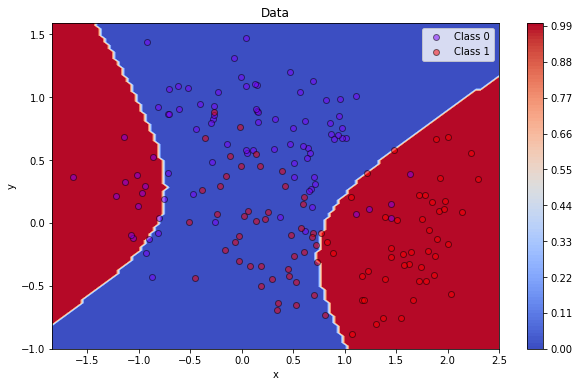

In [13]:
pl.figure(figsize = (10, 6))    
plot_decision_region(X_test_moons, gen_pred_fun(poly_svm))
plot_data(X_test_moons, y_test_moons)

Aunque si lo intentamos con un polinomio de grado $3$:

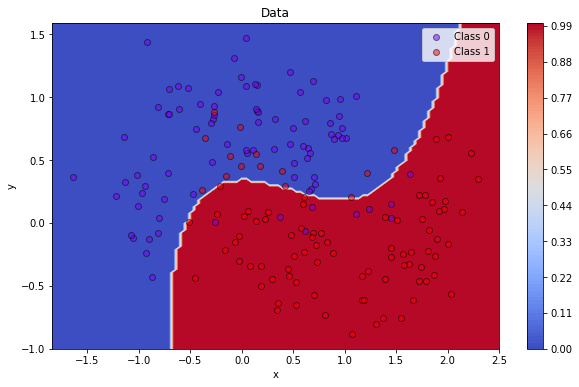

In [14]:
poly_svm = SVC(kernel='poly', degree=3, coef0=1)
poly_svm.fit(X_train_moons, y_train_moons)

pl.figure(figsize = (10, 6))    
plot_decision_region(X_test_moons, gen_pred_fun(poly_svm))
plot_data(X_test_moons, y_test_moons)

Medimos el error en entrenamiento y prueba

In [15]:
print("Error en entrenamiento: {}".format(1-poly_svm.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-poly_svm.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.09523809523809523
Error en prueba: 0.12777777777777777


Ahora probamos con el conjunto de datos IRIS:

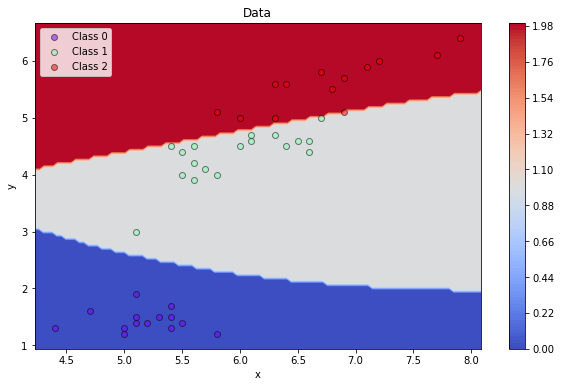

In [16]:
poly_svm = SVC(kernel='poly', degree=4)
poly_svm.fit(X_train_iris, y_train_iris)

pl.figure(figsize = (10, 6))    
plot_decision_region(X_test_iris, gen_pred_fun(poly_svm))
plot_data(X_test_iris, y_test_iris)

In [17]:
print("Error en entrenamiento: {}".format(1-poly_svm.score(X_train_iris, y_train_iris)))
print("Error en prueba: {}".format(1-poly_svm.score(X_test_iris, y_test_iris)))

Error en entrenamiento: 0.03809523809523807
Error en prueba: 0.022222222222222254


## Kernel Gaussiano


$$
K(x, x') = \exp\left(-\frac{\|x-x'\|^2}{2\sigma^2}\right)
$$
la cual se puede simplificar como
$$
K(x, x') = \exp(-\gamma \|x-x'\|^2)
$$

En la literatura este método tambien se encuentra como kernel usando una función de base radial (**RBF** por sus siglas en ingles). En el siguiente ejemplo probamos con un valor de $\gamma$ pequeño:

In [18]:
rbf_svm = SVC(kernel='rbf', gamma = 0.007)
rbf_svm.fit(X_train_moons, y_train_moons);

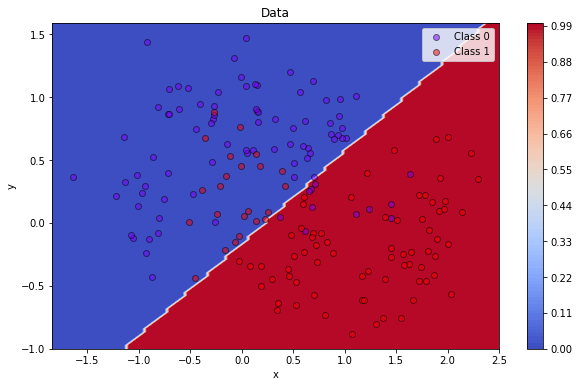

In [19]:
pl.figure(figsize = (10, 6))    
plot_decision_region(X_test_moons, gen_pred_fun(rbf_svm))
plot_data(X_test_moons, y_test_moons)

Reportamos el error de entrenamiento y prueba:

In [20]:
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.16190476190476188
Error en prueba: 0.18888888888888888


Usamos un $\gamma$ más grande

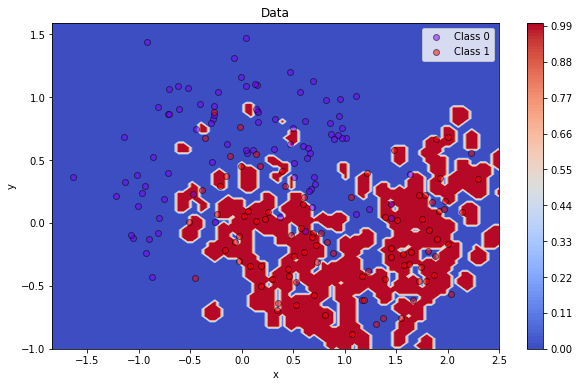

In [21]:
rbf_svm = SVC(kernel='rbf', gamma = 1000)
rbf_svm.fit(X_train_moons, y_train_moons)

pl.figure(figsize = (10, 6))    
plot_decision_region(X_test_moons, gen_pred_fun(rbf_svm))
plot_data(X_test_moons, y_test_moons)

Ahora reportamos el error de entrenamiento y prueba:

In [22]:
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.0
Error en prueba: 0.22777777777777775


Ahora escogemos un valor de $\gamma$ intermedio

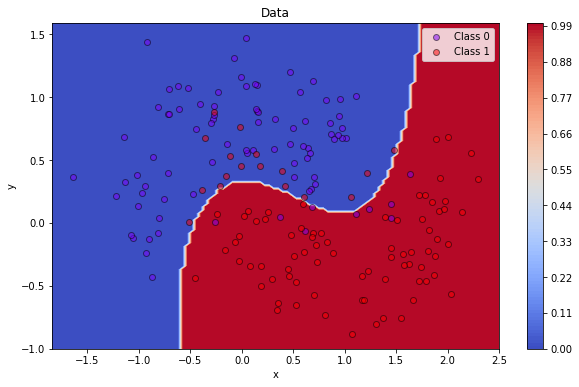

In [23]:
rbf_svm = SVC(kernel='rbf', gamma = 0.7)
rbf_svm.fit(X_train_moons, y_train_moons)

pl.figure(figsize = (10, 6))    
plot_decision_region(X_test_moons, gen_pred_fun(rbf_svm))
plot_data(X_test_moons, y_test_moons)

In [24]:
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.08809523809523812
Error en prueba: 0.1444444444444445


Probamos sobre el conjunto de datos iris

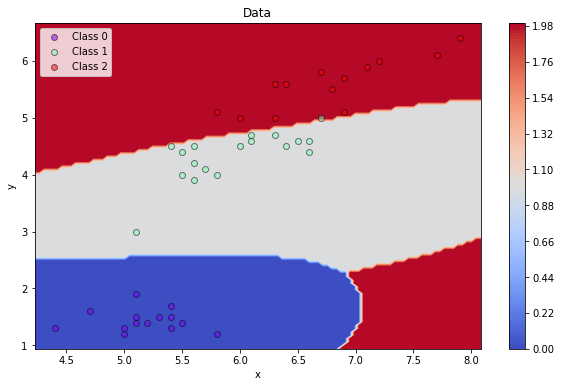

In [25]:
rbf_svm = SVC(kernel='rbf', gamma = 0.7)
rbf_svm.fit(X_train_iris, y_train_iris)

pl.figure(figsize = (10, 6))    
plot_decision_region(X_test_iris, gen_pred_fun(rbf_svm))
plot_data(X_test_iris, y_test_iris)

Finalmente reportamos el error en entrenamiento y prueba:

In [26]:
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_train_iris, y_train_iris)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_test_iris, y_test_iris)))

Error en entrenamiento: 0.02857142857142858
Error en prueba: 0.022222222222222254


# Estimando de una forma más robusta los hiperparámetros del modelo

Hasta el momento nos hemos concentrado en evaluar nuestros modelos en una partición de prueba. Sin embargo, es común introducir sobreajuste a través de la modificación manual de los hiperparámetros de un modelo conforme vamos reportando el error de generalización sobre el conjunto de prueba.

<img src="figures/train_val.svg" width="70%">

En la anterior imagen, introducimos una nueva partición, conocida como partición de "**validación**". Esta partición es resultado de tomar la partición de entrenamiento y volver a dividirla (en entrenamiento y validación) de tal forma que cualquier configuración de parámetros que se use para entrenar un modelo, pueda ser reportada en **validación**. Una vez estemos seguros que tenemos el modelo con el mejor desempeño en **validación**, volvemos a unir ambas particiones, entrenamos un modelo sobre la partición original de entrenamiento y reportamos **una sola vez** en el conjunto de prueba.

# Validación cruzada de  k pliegues

A pesar de que se introdujo una nueva partición para validar los parámetros de un modelo, se sigue usando una partición reducida para entrenar el conjunto de datos. La validación cruzada nos permite usar una mayor parte de los datos para construír el modelo y generar un estimador más robusto y con mayor capacidad de generalización. En validación cruzada, los datos son particionados varias veces en entrenamiento y validación de forma repetida. Finalmente el desempeño del clasificador es agregado sobre las diferentes particiones de validación para obtener un estimador más robusto.

La validación cruzada se hace comúnmente de la siguiente manera:
* Se divide el conjunto de entrenamiento en k-pliegues o particiones (usualmente 3, 5 o 10).
* Estas particiones deben ser del mismo tamaño
* En cada iteración uno de los pliegues es usado como la partición de validación, mientras el resto es usado como la partición de entrenamiento.
* Se reporta y guarda el desempeño sobre esa partición de validación

<img src="figures/cv2.svg" width="70%">

Vamos a usar el conjunto de datos IRIS y construímos cada uno de los pliegues:

In [27]:
X = iris.data
y = iris.target

classifier = LinearSVC()

k = 5
n_samples = len(X)
fold_size = n_samples // k
print('Tamaño de cada pliegue: {}'.format(fold_size))

Tamaño de cada pliegue: 30


Primero hacemos un reordenamiento aleatorio de los datos. De tal forma que las clases estén distribuídas a lo largo de los $k$-pliegues.

In [28]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=0)

Para cada pliegue vamos a construir una máscara sobre los datos, que indicará mi partición de entrenamiento y de validación.

In [29]:
scores = []
masks = []


for fold in range(k):
    val_mask = np.zeros(n_samples, dtype=bool)
    val_mask[fold * fold_size : (fold + 1) * fold_size] = True
    masks.append(val_mask)
    X_val, y_val = X[val_mask], y[val_mask]
    print('Distribución de etiquetas en el pliegue {}: {}'
          .format(fold, np.bincount(y_val)))
    
    X_train, y_train = X[~val_mask], y[~val_mask]
    classifier.fit(X_train, y_train)
    scores.append(classifier.score(X_val, y_val))

Distribución de etiquetas en el pliegue 0: [11 13  6]
Distribución de etiquetas en el pliegue 1: [ 5 10 15]
Distribución de etiquetas en el pliegue 2: [10 10 10]
Distribución de etiquetas en el pliegue 3: [14  6 10]
Distribución de etiquetas en el pliegue 4: [10 11  9]


A continuación tenemos el accuracy para cada pliegue de **validación** y su respectivo promedio:

In [30]:
print('Accuracy por cada pliegue: {}'.format(scores))
print('Accuracy promedio sobre los 5 pliegues: {}'.format(np.mean(scores)))

Accuracy por cada pliegue: [1.0, 0.8666666666666667, 1.0, 0.96666666666666667, 0.93333333333333335]
Accuracy promedio sobre los 5 pliegues: 0.9533333333333334


Podemos tambien observar la porción de los datos usados para cada pliegue. En negro encontramos aquel porcentaje usado para validación.

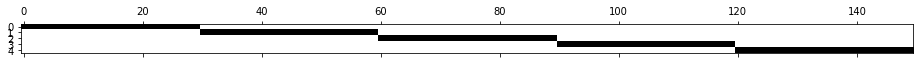

In [31]:
pl.matshow(masks, cmap='gray_r')

## Validación cruzada usando Scikit-Learn

Scikit-Learn provee una implementación muy eficiente para realizar **validación cruzada** usando `sklearn.model_selection`. `sklearn.model_selection.cross_val_score` recibe un estimador y un conjunto de datos, luego 
hace el particionamiento y entrena un modelo sobre cada partición de validación.

In [32]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

El parámetro `cv` en `cross_val_score` controla el número de pliegues a usar.

In [33]:
X = iris.data
y = iris.target

scores = cross_val_score(classifier, X, y, cv=5)
print('Accuracy por cada pliegue: {}'.format(scores))
print('Accuracy promedio sobre los 5 pliegues: {}'.format(np.mean(scores)))

Accuracy por cada pliegue: [ 1.          1.          0.93333333  0.9         1.        ]
Accuracy promedio sobre los 5 pliegues: 0.9666666666666668


`cross_val_score` realiza por defecto una partición estratificada usando `sklearn.model_selection.StratifiedKFold`. Esta estrategia consiste en hacer un particionamiento de tal forma que cada partición tenga la misma distribución de etiquetas $y$. En caso que no se quiera hacer una partición estratificada, se puede usar `sklearn.model_selection.KFold`.

`sklearn.model_selection.StratifiedKFold` genera de forma automática la partición estratificada, sin necesidad de hacer una permutación de los datos como lo hicimos anteriormente. A continuación revisamos los índices que genera `StratifiedKFold`:

In [34]:
cv = StratifiedKFold(n_splits=5)

for train, val in cv.split(iris.data, iris.target):
    print(val)
    print('Tamaño entrenamiento: {}'.format(len(train)))
    print('Tamaño validación: {}'.format(len(val)))

[  0   1   2   3   4   5   6   7   8   9  50  51  52  53  54  55  56  57
  58  59 100 101 102 103 104 105 106 107 108 109]
Tamaño entrenamiento: 120
Tamaño validación: 30
[ 10  11  12  13  14  15  16  17  18  19  60  61  62  63  64  65  66  67
  68  69 110 111 112 113 114 115 116 117 118 119]
Tamaño entrenamiento: 120
Tamaño validación: 30
[ 20  21  22  23  24  25  26  27  28  29  70  71  72  73  74  75  76  77
  78  79 120 121 122 123 124 125 126 127 128 129]
Tamaño entrenamiento: 120
Tamaño validación: 30
[ 30  31  32  33  34  35  36  37  38  39  80  81  82  83  84  85  86  87
  88  89 130 131 132 133 134 135 136 137 138 139]
Tamaño entrenamiento: 120
Tamaño validación: 30
[ 40  41  42  43  44  45  46  47  48  49  90  91  92  93  94  95  96  97
  98  99 140 141 142 143 144 145 146 147 148 149]
Tamaño entrenamiento: 120
Tamaño validación: 30


Usando una función definida previamente, vamos a validar la distribución de las etiquetas por clase.

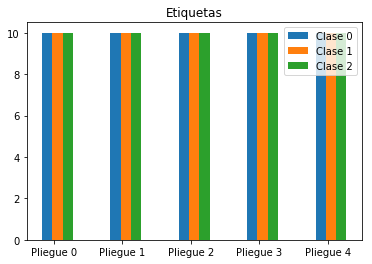

In [35]:
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds)
y = iris.target

y_labels = []
for _, val in cv.split(iris.data, iris.target):
    y_labels.append(y[val])

plot_labels(n_folds, 3, y_labels)

Por otro lado, usando `KFold` podemos obtener un particionamiento de tantos pliegues como se especifiquen. Sin embargo, se corre el riesgo de no generar particiones balanceadas, por lo tanto lo estimadores no van a tener el desempeño esperado. Por ejemplo en el **Pliegue 0** solo hay datos de la clase $0$.

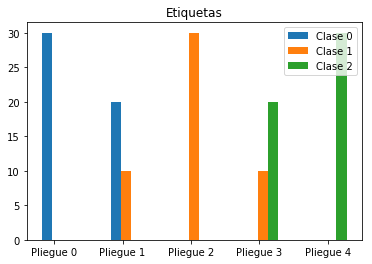

In [36]:
n_folds = 5
cv = KFold(n_splits=n_folds)
y = iris.target

y_labels = []
for _, val in cv.split(iris.data, iris.target):
    y_labels.append(y[val])

plot_labels(n_folds, 3, y_labels)

# Grid search

SVM usando RBF comúnmente requiere el ajuste de dos parámetros:
* `gamma`
* `C`

Ambos parámetros pueden ser explorados usando un retículo (grid) de parámetros y evaluando su desempeño usando validación cruzada de $k$ pliegues. A continuación, creamos una partición entrenamiento y prueba sobre el conjunto de datos IRIS.

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 
# Exploración de parámetros solo con X_train
# si se quiere esta muestra estratificada parámetro stratify = y -> variable respuesta

Definimos los siguientes valores para $C$ y $\textit{gamma}$.

In [38]:
grid = [i for i in range(-5, 7, 1)]
param_grid = {'C': [2**i for i in grid], 'gamma': [2**i for i in grid]}

Valores de $C$:

In [39]:
print(param_grid['C'])

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]


Valores de $\textit{gamma}$:

In [40]:
print(param_grid['gamma'])

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]


`GridSearchCV` recibe dos elementos fundamentales:
* `estimator`: Modelo de Scikit-Learn. Puede ser `SVC(kernel='rbf')`.
* `param_grid`: Diccionario que contiene los parámetros que se van a explorar usando validación cruzada.

In [41]:
clf = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, verbose=2)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.0625 .........................................
[CV] .......................... C=0.03125, gamma=0.0625, total=   0.0s
[CV] C=0.03125, gamma=0.0625 .........................................
[CV] .......................... C=0.03125, gamma=0.0625, total=   0.0s
[CV] C=0.03125, gamma=0.0625 .........................................
[CV] .......................... C=0.03125, gamma=0.0625, total=   0.0s
[CV] C=0.03125, gamma=0.125 ..........................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. C=0.25, gamma=4, total=   0.0s
[CV] C=0.25, gamma=4 .................................................
[CV] .................................. C=0.25, gamma=4, total=   0.0s
[CV] C=0.25, gamma=8 .................................................
[CV] .................................. C=0.25, gamma=8, total=   0.0s
[CV] C=0.25, gamma=8 .................................................
[CV] .................................. C=0.25, gamma=8, total=   0.0s
[CV] C=0.25, gamma=8 .................................................
[CV] .................................. C=0.25, gamma=8, total=   0.0s
[CV] C=0.25, gamma=16 ................................................
[CV] ................................. C=0.25, gamma=16, total=   0.0s
[CV] C=0.25, gamma=16 ................................................
[CV] ................................. C=0.25, gamma=16, total=   0.0s
[CV] C=0.25, gamma=16 ................................................
[CV] .

[CV] ................................... C=4, gamma=0.5, total=   0.0s
[CV] C=4, gamma=1 ....................................................
[CV] ..................................... C=4, gamma=1, total=   0.0s
[CV] C=4, gamma=1 ....................................................
[CV] ..................................... C=4, gamma=1, total=   0.0s
[CV] C=4, gamma=1 ....................................................
[CV] ..................................... C=4, gamma=1, total=   0.0s
[CV] C=4, gamma=2 ....................................................
[CV] ..................................... C=4, gamma=2, total=   0.0s
[CV] C=4, gamma=2 ....................................................
[CV] ..................................... C=4, gamma=2, total=   0.0s
[CV] C=4, gamma=2 ....................................................
[CV] ..................................... C=4, gamma=2, total=   0.0s
[CV] C=4, gamma=4 ....................................................
[CV] .

[CV] ................................ C=64, gamma=0.125, total=   0.0s
[CV] C=64, gamma=0.125 ...............................................
[CV] ................................ C=64, gamma=0.125, total=   0.0s
[CV] C=64, gamma=0.25 ................................................
[CV] ................................. C=64, gamma=0.25, total=   0.0s
[CV] C=64, gamma=0.25 ................................................
[CV] ................................. C=64, gamma=0.25, total=   0.0s
[CV] C=64, gamma=0.25 ................................................
[CV] ................................. C=64, gamma=0.25, total=   0.0s
[CV] C=64, gamma=0.5 .................................................
[CV] .................................. C=64, gamma=0.5, total=   0.0s
[CV] C=64, gamma=0.5 .................................................
[CV] .................................. C=64, gamma=0.5, total=   0.0s
[CV] C=64, gamma=0.5 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:    0.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64], 'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Los valores promedio de accuracy para cada combinación de hiperparámetros se pueden extraer usando `GridSearchCV.cv_results_`. Convertimos ese diccionario a un DataFrame de pandas.

In [42]:
import pandas as pd

cv_results = pd.DataFrame(clf.cv_results_)
cv_results

# rank score puntua la configuración

C:\Users\Estudiante\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Estudiante\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Estudiante\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Estudiante\Anaconda3\lib\site-pac

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000667,0.000000,0.466667,0.468303,0.03125,0.03125,"{'C': 0.03125, 'gamma': 0.03125}",127,0.694444,0.695652,0.342857,0.357143,0.352941,0.352113,2.360224e-04,0.000000e+00,0.164578,0.160774
1,0.000500,0.000000,0.695238,0.695264,0.03125,0.0625,"{'C': 0.03125, 'gamma': 0.0625}",105,0.694444,0.695652,0.685714,0.700000,0.705882,0.690141,4.899036e-07,0.000000e+00,0.008194,0.004034
2,0.000659,0.000334,0.695238,0.695264,0.03125,0.125,"{'C': 0.03125, 'gamma': 0.125}",105,0.694444,0.695652,0.685714,0.700000,0.705882,0.690141,2.340929e-04,2.359120e-04,0.008194,0.004034
3,0.000666,0.000000,0.695238,0.695264,0.03125,0.25,"{'C': 0.03125, 'gamma': 0.25}",105,0.694444,0.695652,0.685714,0.700000,0.705882,0.690141,2.343366e-04,0.000000e+00,0.008194,0.004034
4,0.000333,0.000501,0.647619,0.676418,0.03125,0.5,"{'C': 0.03125, 'gamma': 0.5}",111,0.694444,0.695652,0.600000,0.685714,0.647059,0.647887,2.357976e-04,2.247832e-07,0.038829,0.020578
5,0.000664,0.000167,0.466667,0.468303,0.03125,1,"{'C': 0.03125, 'gamma': 1}",127,0.694444,0.695652,0.342857,0.357143,0.352941,0.352113,2.388126e-04,2.360224e-04,0.164578,0.160774
6,0.000500,0.000334,0.466667,0.463472,0.03125,2,"{'C': 0.03125, 'gamma': 2}",127,0.694444,0.681159,0.342857,0.357143,0.352941,0.352113,2.247832e-07,2.360787e-04,0.164578,0.153942
7,0.000500,0.000500,0.457143,0.453810,0.03125,4,"{'C': 0.03125, 'gamma': 4}",130,0.666667,0.652174,0.342857,0.357143,0.352941,0.352113,1.123916e-07,2.973602e-07,0.151397,0.140280
8,0.000500,0.000501,0.447619,0.448979,0.03125,8,"{'C': 0.03125, 'gamma': 8}",131,0.638889,0.637681,0.342857,0.357143,0.352941,0.352113,1.946680e-07,2.247832e-07,0.138218,0.133448
9,0.000501,0.000500,0.419048,0.448979,0.03125,16,"{'C': 0.03125, 'gamma': 16}",134,0.555556,0.637681,0.342857,0.357143,0.352941,0.352113,2.973602e-07,1.946680e-07,0.098686,0.133448


A continuación, observamos que el número de filas de ese DataFrame corresponde al número de configuraciones de hiperparámetros que se están explorando:

In [43]:
print(len(cv_results))
print(len(param_grid['C'])*len(param_grid['gamma']))

144
144


Usando la columna `mean_test_score`, extraemos los accuracy promedio de la siguiente forma:

In [44]:
scores = clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']),
                                                    len(param_grid['gamma']))

In [45]:
scores # para diferentes combinaciones de c y de gamma

array([[ 0.46666667,  0.6952381 ,  0.6952381 ,  0.6952381 ,  0.64761905,
         0.46666667,  0.46666667,  0.45714286,  0.44761905,  0.41904762,
         0.40952381,  0.40952381],
       [ 0.6952381 ,  0.6952381 ,  0.71428571,  0.75238095,  0.82857143,
         0.74285714,  0.63809524,  0.48571429,  0.44761905,  0.41904762,
         0.40952381,  0.40952381],
       [ 0.6952381 ,  0.76190476,  0.92380952,  0.94285714,  0.93333333,
         0.92380952,  0.87619048,  0.64761905,  0.51428571,  0.41904762,
         0.40952381,  0.40952381],
       [ 0.82857143,  0.93333333,  0.95238095,  0.96190476,  0.96190476,
         0.96190476,  0.95238095,  0.92380952,  0.62857143,  0.5047619 ,
         0.41904762,  0.40952381],
       [ 0.94285714,  0.96190476,  0.96190476,  0.97142857,  0.96190476,
         0.96190476,  0.95238095,  0.95238095,  0.9047619 ,  0.62857143,
         0.4952381 ,  0.42857143],
       [ 0.96190476,  0.96190476,  0.97142857,  0.97142857,  0.97142857,
         0.97142857,  

A continuación, presentamos una forma de visualizar esta exploración sobre la malla de hiperparámetros

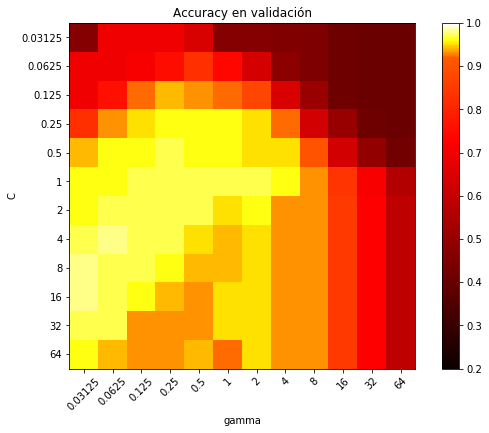

In [46]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92, vmax=1.))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Accuracy en validación')
plt.show()

# La región muestra buenos resultados rodeado de varios malos, es decir la zona nos puede dejar ver con claridad los valores de
# los parámetros que se puede escoger si el gráfico no es claro se puede escoger otro rango

Encontramos que existen tres modelos con el mejor desempeño usando validación cruzada:
* $C=4$ y $\gamma=0.0625$
* $C=8$ y $\gamma=0.03125$
* $C=16$ y $\gamma=0.03125$
 
Para validar esta información, `GridSearchCV` nos ofrece una serie de métodos que nos permite consultar:
* La lista de resultados por elemento en la malla de parámetros (`cv_results_`)
* La configuración con el mejor desempeño (`best_params_`)
* El accuracy promediado sobre todos los pliegues de la mejor configuración (`best_score_`)

Para encontrar las mejores configuraciones, ordenamos la tabla de resultados de la siguiente manera:

In [47]:
cv_results = cv_results[['param_C', 'param_gamma', 'mean_test_score']]
cv_results.sort_values(by='mean_test_score', ascending=False).head()

,param_C,param_gamma,mean_test_score
96,8,0.03125,0.980952
85,4,0.0625,0.980952
108,16,0.03125,0.980952
97,8,0.0625,0.971429
87,4,0.25,0.971429


Esta información también se puede consultar usando `.best_params_` y `.best_score_`.

In [48]:
print(clf.best_params_)

{'C': 4, 'gamma': 0.0625}


In [49]:
print(clf.best_score_)

0.980952380952


Una vez se haya entrenado el modelo usando validación cruzada, `GridSearchCV` escoge automáticamente la mejor configuración y vuelve a entrenar un modelo sobre todo el conjunto de datos de entrenamiento. Por lo tanto se pueden hacer llamados a funciones como `predict()` y `score()`.

Para reportar sobre el conjunto de prueba basta con:

In [50]:
clf.score(X_test, y_test)

0.97777777777777775

# Taller

Siguiendo con el conjunto de datos **Wine**.

# Realice:

* Cargue el conjunto de datos **Wine**.

## Explorando `Proline` contra `Flavonoids`
* Construya un conjunto de datos usando las características `Proline` contra `Flavonoids`.
* Escale el conjunto de datos de tal forma que tenga media cero y varianza uno:

```python
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_x.fit(X)
X_scaled = sc_x.transform(X)
```

* Genere una partición estratificada 70-30 sobre el conjunto de datos.
* Genere una gráfica de la distribución de etiquetas tanto en entrenamiento como en prueba. Recuerde que la etiqueta es la columna `Class`.
* Use la siguiente retícula de parámetros:

```python
grid = [i for i in range(-5, 7, 1)]
param_grid = {'C': [2**i for i in grid], 'gamma': [2**i for i in grid]}
```
*  Explore el parámetro óptimo $\gamma$ y $C$ para un SVM con kernel gaussiano. Hágalo en 5 pliegues.
* Visualice el desempeño del clasificador sobre la retícula de parámetros como un mapa de calor. Use el código que se manejó en la sesión.
* ¿Cual es la mejor configuración?
* ¿Qué desempeño tiene la mejor configuración?
* Grafique la superficie de decisión contra los ejemplos de prueba.
* Reporte accuracy, precision, recall y matriz de confusión en el conjunto de prueba

## Usando todas las características
* Escale **todo** el conjunto de datos de tal forma que tenga media cero y varianza uno. Use el código que se proporcionó arriba.
* Genere una partición estratificada 70-30 sobre el conjunto de datos.
* Use la siguiente retícula de parámetros:

```python
grid = [i for i in range(-7, 8, 1)]
param_grid = {'C': [2**i for i in grid], 'gamma': [2**i for i in grid]}
```
*  Explore el parámetro óptimo $\gamma$ y $C$ para un SVM con kernel gaussiano. Hágalo en 5 pliegues.
* Visualice el desempeño del clasificador sobre la retícula de parámetros como un mapa de calor. Use el código que se manejó en la sesión.
* ¿Cual es la mejor configuración?
* ¿Qué desempeño tiene la mejor configuración?
* Reporte accuracy, precision, recall y matriz de confusión en el conjunto de prueba

In [97]:
## Explorando Proline contra Flavonoids
# Construya un conjunto de datos usando las características Proline contra Flavonoids.
data  = pd.read_csv('winedata.txt')
y = data['Class']
df = data.drop('Class',axis=1)

keys = df.keys()
X = df[[keys[6],keys[-1]]]

# Escale el conjunto de datos de tal forma que tenga media cero y varianza uno:

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_x.fit(X)
X_scaled = sc_x.transform(X)

# Genere una partición estratificada 70-30 sobre el conjunto de datos.

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1983,stratify=y)

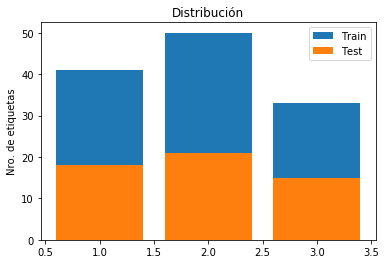

In [98]:
# Genere una gráfica de la distribución de etiquetas tanto en entrenamiento como en prueba. Recuerde que la etiqueta es la columna Class.

#y.values

uni_train = y_train.value_counts().reset_index()
uni_test = y_test.value_counts().reset_index()

plot1 = plt.bar(uni_train['index'],uni_train['Class'])
plot2 = plt.bar(uni_test['index'],uni_test['Class'])
plt.title("Distribución")
plt.ylabel("Nro. de etiquetas")
plt.legend(("Train","Test"))


In [99]:
# Use la siguiente retícula de parámetros:

grid = [i for i in range(-5, 7, 1)]
param_grid = {'C': [2**i for i in grid], 'gamma': [2**i for i in grid]}

# Explore el parámetro óptimo  γγ  y  CC  para un SVM con kernel gaussiano.
# Hágalo en 5 pliegues.

clf = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, verbose=2,cv=5)
clf
clf.fit(X_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.0625 .........................................
[CV] .......................... C=0.03125, gamma=0.0625, total=   0.0s
[CV] C=0.03125, gamma=0.0625 .........................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.0625, gamma=8 ...............................................
[CV] ................................ C=0.0625, gamma=8, total=   0.0s
[CV] C=0.0625, gamma=8 ...............................................
[CV] ................................ C=0.0625, gamma=8, total=   0.0s
[CV] C=0.0625, gamma=8 ...............................................
[CV] ................................ C=0.0625, gamma=8, total=   0.0s
[CV] C=0.0625, gamma=8 ...............................................
[CV] ................................ C=0.0625, gamma=8, total=   0.0s
[CV] C=0.0625, gamma=16 ..............................................
[CV] ............................... C=0.0625, gamma=16, total=   0.0s
[CV] C=0.0625, gamma=16 ..............................................
[CV] ............................... C=0.0625, gamma=16, total=   0.0s
[CV] C=0.0625, gamma=16 ..............................................
[CV] ............................... C=0.0625, gamma=16, total=   0.0s
[CV] 

[CV] ................................ C=0.25, gamma=0.5, total=   0.0s
[CV] C=0.25, gamma=1 .................................................
[CV] .................................. C=0.25, gamma=1, total=   0.0s
[CV] C=0.25, gamma=1 .................................................
[CV] .................................. C=0.25, gamma=1, total=   0.0s
[CV] C=0.25, gamma=1 .................................................
[CV] .................................. C=0.25, gamma=1, total=   0.0s
[CV] C=0.25, gamma=1 .................................................
[CV] .................................. C=0.25, gamma=1, total=   0.0s
[CV] C=0.25, gamma=1 .................................................
[CV] .................................. C=0.25, gamma=1, total=   0.0s
[CV] C=0.25, gamma=2 .................................................
[CV] .................................. C=0.25, gamma=2, total=   0.0s
[CV] C=0.25, gamma=2 .................................................
[CV] .

[CV] ................................. C=1, gamma=0.125, total=   0.0s
[CV] C=1, gamma=0.125 ................................................
[CV] ................................. C=1, gamma=0.125, total=   0.0s
[CV] C=1, gamma=0.25 .................................................
[CV] .................................. C=1, gamma=0.25, total=   0.0s
[CV] C=1, gamma=0.25 .................................................
[CV] .................................. C=1, gamma=0.25, total=   0.0s
[CV] C=1, gamma=0.25 .................................................
[CV] .................................. C=1, gamma=0.25, total=   0.0s
[CV] C=1, gamma=0.25 .................................................
[CV] .................................. C=1, gamma=0.25, total=   0.0s
[CV] C=1, gamma=0.25 .................................................
[CV] .................................. C=1, gamma=0.25, total=   0.0s
[CV] C=1, gamma=0.5 ..................................................
[CV] .

[CV] ............................... C=4, gamma=0.03125, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.125 ................................................
[CV] ................................. C=4, gamma=0.125, total=   0.0s
[CV] C=4, gamma=0.125 ................................................
[CV] .

[CV] .................................... C=8, gamma=32, total=   0.0s
[CV] C=8, gamma=64 ...................................................
[CV] .................................... C=8, gamma=64, total=   0.0s
[CV] C=8, gamma=64 ...................................................
[CV] .................................... C=8, gamma=64, total=   0.0s
[CV] C=8, gamma=64 ...................................................
[CV] .................................... C=8, gamma=64, total=   0.0s
[CV] C=8, gamma=64 ...................................................
[CV] .................................... C=8, gamma=64, total=   0.0s
[CV] C=8, gamma=64 ...................................................
[CV] .................................... C=8, gamma=64, total=   0.0s
[CV] C=16, gamma=0.03125 .............................................
[CV] .............................. C=16, gamma=0.03125, total=   0.0s
[CV] C=16, gamma=0.03125 .............................................
[CV] .

[CV] ................................... C=32, gamma=16, total=   0.0s
[CV] C=32, gamma=16 ..................................................
[CV] ................................... C=32, gamma=16, total=   0.0s
[CV] C=32, gamma=16 ..................................................
[CV] ................................... C=32, gamma=16, total=   0.0s
[CV] C=32, gamma=16 ..................................................
[CV] ................................... C=32, gamma=16, total=   0.0s
[CV] C=32, gamma=32 ..................................................
[CV] ................................... C=32, gamma=32, total=   0.0s
[CV] C=32, gamma=32 ..................................................
[CV] ................................... C=32, gamma=32, total=   0.0s
[CV] C=32, gamma=32 ..................................................
[CV] ................................... C=32, gamma=32, total=   0.0s
[CV] C=32, gamma=32 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64], 'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

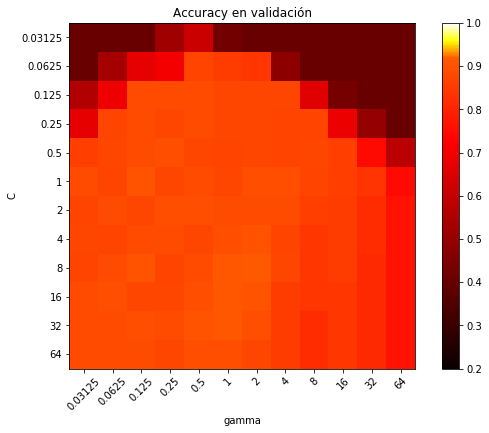

{'C': 8, 'gamma': 2}
0.91935483871


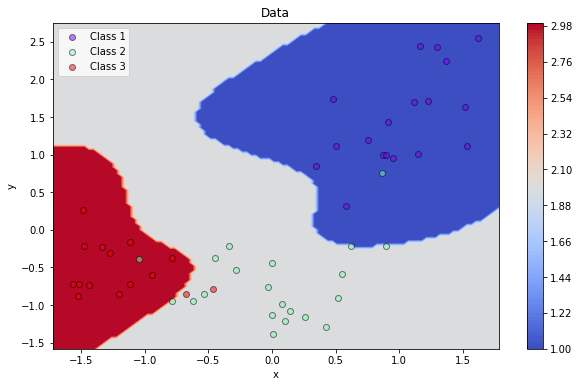

In [100]:

# Visualice el desempeño del clasificador sobre la retícula de parámetros como un mapa de calor.
# Use el código que se manejó en la sesión.

scores = clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']),
                                                    len(param_grid['gamma']))
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92, vmax=1.))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Accuracy en validación')
plt.show()

# ¿Cual es la mejor configuración?

print(clf.best_params_)


# ¿Qué desempeño tiene la mejor configuración?
print(clf.best_score_)

# Grafique la superficie de decisión contra los ejemplos de prueba.

pl.figure(figsize = (10, 6))    
plot_decision_region(X_test, gen_pred_fun(clf))
plot_data(X_test, y_test)

In [101]:
# Reporte accuracy, precision, recall y matriz de confusión en el conjunto de prueba

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, f1_score

y_testpred = clf.predict(X_test)
y_testpred
matest = confusion_matrix(y_test, y_testpred)

print(matest)
print('Accuracy knn classifier: {}'.format(clf.score(X_test, y_test)))
print('Error knn classifier: {}'.format(1-clf.score(X_test, y_test)))
print('Recall macro: {}'.format(recall_score(y_test, y_testpred, average='macro')))
print('F1 macro: {}'.format(f1_score(y_test, y_testpred, average='macro')))


[[18  0  0]
 [ 3 17  1]
 [ 0  2 13]]
Accuracy knn classifier: 0.8888888888888888
Error knn classifier: 0.11111111111111116
Recall macro: 0.8920634920634921
F1 macro: 0.8898762157382847


In [102]:
# Usando todas las características

data  = pd.read_csv('winedata.txt')
y = data['Class']
df = data.drop('Class',axis=1)
df_all = df

# Escale todo el conjunto de datos de tal forma que tenga media cero y varianza uno. Use el código que se proporcionó arriba.

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_x.fit(df_all)
Xall_scaled = sc_x.transform(df_all)

# Genere una partición estratificada 70-30 sobre el conjunto de datos.

Xall_train, Xall_test, yall_train, yall_test = train_test_split(Xall_scaled, y, test_size=0.3, random_state=1)




In [103]:
# Use la siguiente retícula de parámetros:

grid = [i for i in range(-7, 8, 1)]
param_grid = {'C': [2**i for i in grid], 'gamma': [2**i for i in grid]}

# Explore el parámetro óptimo  γγ  y  CC  para un SVM con kernel gaussiano. Hágalo en 5 pliegues.

n_folds = 5
cv = StratifiedKFold(n_splits=n_folds)

clf_all = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, verbose=2,cv=cv)
clf_all
clf_all.fit(Xall_train, yall_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV] C=0.0078125, gamma=0.0078125 ....................................
[CV] ..................... C=0.0078125, gamma=0.0078125, total=   0.0s
[CV] C=0.0078125, gamma=0.0078125 ....................................
[CV] ..................... C=0.0078125, gamma=0.0078125, total=   0.0s
[CV] C=0.0078125, gamma=0.0078125 ....................................
[CV] ..................... C=0.0078125, gamma=0.0078125, total=   0.0s
[CV] C=0.0078125, gamma=0.0078125 ....................................
[CV] ..................... C=0.0078125, gamma=0.0078125, total=   0.0s
[CV] C=0.0078125, gamma=0.0078125 ....................................
[CV] ..................... C=0.0078125, gamma=0.0078125, total=   0.0s
[CV] C=0.0078125, gamma=0.015625 .....................................
[CV] ...................... C=0.0078125, gamma=0.015625, total=   0.0s
[CV] C=0.0078125, gamma=0.015625 .....................................
[CV] ........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.015625, gamma=0.015625 ......................................
[CV] ....................... C=0.015625, gamma=0.015625, total=   0.0s
[CV] C=0.015625, gamma=0.015625 ......................................
[CV] ....................... C=0.015625, gamma=0.015625, total=   0.0s
[CV] C=0.015625, gamma=0.03125 .......................................
[CV] ........................ C=0.015625, gamma=0.03125, total=   0.0s
[CV] C=0.015625, gamma=0.03125 .......................................
[CV] ........................ C=0.015625, gamma=0.03125, total=   0.0s
[CV] C=0.015625, gamma=0.03125 .......................................
[CV] ........................ C=0.015625, gamma=0.03125, total=   0.0s
[CV] C=0.015625, gamma=0.03125 .......................................
[CV] ........................ C=0.015625, gamma=0.03125, total=   0.0s
[CV] C=0.015625, gamma=0.03125 .......................................
[CV] ........................ C=0.015625, gamma=0.03125, total=   0.0s
[CV] 

[CV] .......................... C=0.03125, gamma=0.0625, total=   0.0s
[CV] C=0.03125, gamma=0.0625 .........................................
[CV] .......................... C=0.03125, gamma=0.0625, total=   0.0s
[CV] C=0.03125, gamma=0.125 ..........................................
[CV] ........................... C=0.03125, gamma=0.125, total=   0.0s
[CV] C=0.03125, gamma=0.125 ..........................................
[CV] ........................... C=0.03125, gamma=0.125, total=   0.0s
[CV] C=0.03125, gamma=0.125 ..........................................
[CV] ........................... C=0.03125, gamma=0.125, total=   0.0s
[CV] C=0.03125, gamma=0.125 ..........................................
[CV] ........................... C=0.03125, gamma=0.125, total=   0.0s
[CV] C=0.03125, gamma=0.125 ..........................................
[CV] ........................... C=0.03125, gamma=0.125, total=   0.0s
[CV] C=0.03125, gamma=0.25 ...........................................
[CV] .

[CV] ............................. C=0.0625, gamma=0.25, total=   0.0s
[CV] C=0.0625, gamma=0.5 .............................................
[CV] .............................. C=0.0625, gamma=0.5, total=   0.0s
[CV] C=0.0625, gamma=0.5 .............................................
[CV] .............................. C=0.0625, gamma=0.5, total=   0.0s
[CV] C=0.0625, gamma=0.5 .............................................
[CV] .............................. C=0.0625, gamma=0.5, total=   0.0s
[CV] C=0.0625, gamma=0.5 .............................................
[CV] .............................. C=0.0625, gamma=0.5, total=   0.0s
[CV] C=0.0625, gamma=0.5 .............................................
[CV] .............................. C=0.0625, gamma=0.5, total=   0.0s
[CV] C=0.0625, gamma=1 ...............................................
[CV] ................................ C=0.0625, gamma=1, total=   0.0s
[CV] C=0.0625, gamma=1 ...............................................
[CV] .

[CV] ................................. C=0.125, gamma=2, total=   0.0s
[CV] C=0.125, gamma=2 ................................................
[CV] ................................. C=0.125, gamma=2, total=   0.0s
[CV] C=0.125, gamma=2 ................................................
[CV] ................................. C=0.125, gamma=2, total=   0.0s
[CV] C=0.125, gamma=2 ................................................
[CV] ................................. C=0.125, gamma=2, total=   0.0s
[CV] C=0.125, gamma=2 ................................................
[CV] ................................. C=0.125, gamma=2, total=   0.0s
[CV] C=0.125, gamma=4 ................................................
[CV] ................................. C=0.125, gamma=4, total=   0.0s
[CV] C=0.125, gamma=4 ................................................
[CV] ................................. C=0.125, gamma=4, total=   0.0s
[CV] C=0.125, gamma=4 ................................................
[CV] .

[CV] .................................. C=0.25, gamma=8, total=   0.0s
[CV] C=0.25, gamma=8 .................................................
[CV] .................................. C=0.25, gamma=8, total=   0.0s
[CV] C=0.25, gamma=8 .................................................
[CV] .................................. C=0.25, gamma=8, total=   0.0s
[CV] C=0.25, gamma=8 .................................................
[CV] .................................. C=0.25, gamma=8, total=   0.0s
[CV] C=0.25, gamma=16 ................................................
[CV] ................................. C=0.25, gamma=16, total=   0.0s
[CV] C=0.25, gamma=16 ................................................
[CV] ................................. C=0.25, gamma=16, total=   0.0s
[CV] C=0.25, gamma=16 ................................................
[CV] ................................. C=0.25, gamma=16, total=   0.0s
[CV] C=0.25, gamma=16 ................................................
[CV] .

[CV] .................................. C=0.5, gamma=32, total=   0.0s
[CV] C=0.5, gamma=32 .................................................
[CV] .................................. C=0.5, gamma=32, total=   0.0s
[CV] C=0.5, gamma=64 .................................................
[CV] .................................. C=0.5, gamma=64, total=   0.0s
[CV] C=0.5, gamma=64 .................................................
[CV] .................................. C=0.5, gamma=64, total=   0.0s
[CV] C=0.5, gamma=64 .................................................
[CV] .................................. C=0.5, gamma=64, total=   0.0s
[CV] C=0.5, gamma=64 .................................................
[CV] .................................. C=0.5, gamma=64, total=   0.0s
[CV] C=0.5, gamma=64 .................................................
[CV] .................................. C=0.5, gamma=64, total=   0.0s
[CV] C=0.5, gamma=128 ................................................
[CV] .

[CV] ................................... C=1, gamma=128, total=   0.0s
[CV] C=2, gamma=0.0078125 ............................................
[CV] ............................. C=2, gamma=0.0078125, total=   0.0s
[CV] C=2, gamma=0.0078125 ............................................
[CV] ............................. C=2, gamma=0.0078125, total=   0.0s
[CV] C=2, gamma=0.0078125 ............................................
[CV] ............................. C=2, gamma=0.0078125, total=   0.0s
[CV] C=2, gamma=0.0078125 ............................................
[CV] ............................. C=2, gamma=0.0078125, total=   0.0s
[CV] C=2, gamma=0.0078125 ............................................
[CV] ............................. C=2, gamma=0.0078125, total=   0.0s
[CV] C=2, gamma=0.015625 .............................................
[CV] .............................. C=2, gamma=0.015625, total=   0.0s
[CV] C=2, gamma=0.015625 .............................................
[CV] .

[CV] ............................... C=4, gamma=0.03125, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.0625 ...............................................
[CV] ................................ C=4, gamma=0.0625, total=   0.0s
[CV] C=4, gamma=0.125 ................................................
[CV] ................................. C=4, gamma=0.125, total=   0.0s
[CV] C=4, gamma=0.125 ................................................
[CV] .

[CV] .................................. C=8, gamma=0.25, total=   0.0s
[CV] C=8, gamma=0.25 .................................................
[CV] .................................. C=8, gamma=0.25, total=   0.0s
[CV] C=8, gamma=0.25 .................................................
[CV] .................................. C=8, gamma=0.25, total=   0.0s
[CV] C=8, gamma=0.5 ..................................................
[CV] ................................... C=8, gamma=0.5, total=   0.0s
[CV] C=8, gamma=0.5 ..................................................
[CV] ................................... C=8, gamma=0.5, total=   0.0s
[CV] C=8, gamma=0.5 ..................................................
[CV] ................................... C=8, gamma=0.5, total=   0.0s
[CV] C=8, gamma=0.5 ..................................................
[CV] ................................... C=8, gamma=0.5, total=   0.0s
[CV] C=8, gamma=0.5 ..................................................
[CV] .

[CV] C=16, gamma=1 ...................................................
[CV] .................................... C=16, gamma=1, total=   0.0s
[CV] C=16, gamma=1 ...................................................
[CV] .................................... C=16, gamma=1, total=   0.0s
[CV] C=16, gamma=2 ...................................................
[CV] .................................... C=16, gamma=2, total=   0.0s
[CV] C=16, gamma=2 ...................................................
[CV] .................................... C=16, gamma=2, total=   0.0s
[CV] C=16, gamma=2 ...................................................
[CV] .................................... C=16, gamma=2, total=   0.0s
[CV] C=16, gamma=2 ...................................................
[CV] .................................... C=16, gamma=2, total=   0.0s
[CV] C=16, gamma=2 ...................................................
[CV] .................................... C=16, gamma=2, total=   0.0s
[CV] C

[CV] .................................... C=32, gamma=4, total=   0.0s
[CV] C=32, gamma=4 ...................................................
[CV] .................................... C=32, gamma=4, total=   0.0s
[CV] C=32, gamma=4 ...................................................
[CV] .................................... C=32, gamma=4, total=   0.0s
[CV] C=32, gamma=8 ...................................................
[CV] .................................... C=32, gamma=8, total=   0.0s
[CV] C=32, gamma=8 ...................................................
[CV] .................................... C=32, gamma=8, total=   0.0s
[CV] C=32, gamma=8 ...................................................
[CV] .................................... C=32, gamma=8, total=   0.0s
[CV] C=32, gamma=8 ...................................................
[CV] .................................... C=32, gamma=8, total=   0.0s
[CV] C=32, gamma=8 ...................................................
[CV] .

[CV] C=64, gamma=16 ..................................................
[CV] ................................... C=64, gamma=16, total=   0.0s
[CV] C=64, gamma=16 ..................................................
[CV] ................................... C=64, gamma=16, total=   0.0s
[CV] C=64, gamma=32 ..................................................
[CV] ................................... C=64, gamma=32, total=   0.0s
[CV] C=64, gamma=32 ..................................................
[CV] ................................... C=64, gamma=32, total=   0.0s
[CV] C=64, gamma=32 ..................................................
[CV] ................................... C=64, gamma=32, total=   0.0s
[CV] C=64, gamma=32 ..................................................
[CV] ................................... C=64, gamma=32, total=   0.0s
[CV] C=64, gamma=32 ..................................................
[CV] ................................... C=64, gamma=32, total=   0.0s
[CV] C

[CV] .................................. C=128, gamma=64, total=   0.0s
[CV] C=128, gamma=64 .................................................
[CV] .................................. C=128, gamma=64, total=   0.0s
[CV] C=128, gamma=64 .................................................
[CV] .................................. C=128, gamma=64, total=   0.0s
[CV] C=128, gamma=128 ................................................
[CV] ................................. C=128, gamma=128, total=   0.0s
[CV] C=128, gamma=128 ................................................
[CV] ................................. C=128, gamma=128, total=   0.0s
[CV] C=128, gamma=128 ................................................
[CV] ................................. C=128, gamma=128, total=   0.0s
[CV] C=128, gamma=128 ................................................
[CV] ................................. C=128, gamma=128, total=   0.0s
[CV] C=128, gamma=128 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed:    2.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128], 'gamma': [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

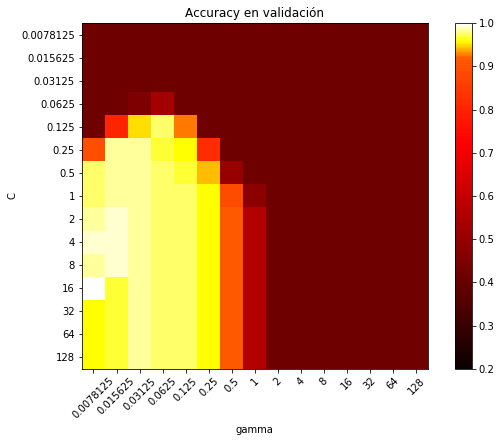

{'C': 16, 'gamma': 0.0078125}
1.0
[[23  0  0]
 [ 0 19  0]
 [ 0  1 11]]
Accuracy classifier: 0.9814814814814815
Error svm all classifier: 0.01851851851851849
Recall svm all macro: 0.9722222222222222
F1 macro: 0.976960237829803


In [104]:
# Visualice el desempeño del clasificador sobre la retícula de parámetros como un mapa de calor. Use el código que se manejó en la sesión.

scores = clf_all.cv_results_['mean_test_score'].reshape(len(param_grid['C']),
                                                    len(param_grid['gamma']))
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92, vmax=1.))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Accuracy en validación')
plt.show()

# ¿Cual es la mejor configuración?

print(clf_all.best_params_)

# ¿Qué desempeño tiene la mejor configuración?

print(clf_all.best_score_)

# Reporte accuracy, precision, recall y matriz de confusión en el conjunto de prueba

y_testpred_all = clf_all.predict(Xall_test)
y_testpred_all
matest = confusion_matrix(yall_test, y_testpred_all)

print(matest)
print('Accuracy classifier: {}'.format(clf_all.score(Xall_test, yall_test)))
print('Error svm all classifier: {}'.format(1-clf_all.score(Xall_test, yall_test)))
print('Recall svm all macro: {}'.format(recall_score(yall_test, y_testpred_all, average='macro')))
print('F1 macro: {}'.format(f1_score(yall_test, y_testpred_all, average='macro')))